# GWAS: Regenie for single variant and rare variant (aggregate tests) analysis in a public data-set

Here we show how to run a genome wide association analysis (GWAS) using regenie with our `regenie.ipynb` pipeline using a public dataset from 1000 genomes. 

This tutorial has been created to be run on a single computer (a desktop, laptop, or a single interactive node on a cluster). The pipeline has been implemented in SoS workflow language and can be configured to run in parallel on a high performance computing cluster environment. Please read the [SoS documentation](https://vatlab.github.io/sos-docs/doc/user_guide/host_setup.html) on how to configure the software and workflow to efficiently perform the analysis for real-world data.

## Introduction

Over the past few years, there have been many tools created to run GWAS with increasing number of samples and genetic variants. Aditionally, these softwares use linear mixed models (LMM) to account for population structure, sample relatedness and estimate the genetic architecture of complex traits. BoltLMM, FastGWA and [Regenie](https://rgcgithub.github.io/regenie/) are some of them. 

Regenie can perform GWAS's in very large datases such as the UK Biobank.

## Regenie properties

1. Works with quantitative and binary traits (case-control), including those with unbalanced samples case-control ratio. Supports Firth logistic regression and Saddle Point Approximation (SPA) for binary traits.
2. Performs linear mixed models (LMM) for quantitative traits and generalized LMM (GLMM) for binary traits using an approximate method. Which allows for the inclusion of related individuals, without increasing type I errors. Even if there are known related indviduals there can be cryptic related individuals and thefore it is advantageous to use LMM/GLMM
3. Offers the advantage of processing multiple phenotypes at the same time. However you should be aware that quantitave or binary traits need to be analyzed separately (phenotype information must be provided in separate files). Also, the proportion of missing data should be similar for all of the traits analyzed at once, since it can impact predictions. Authors of regenie recommend to analyze traits in groups that have similar missingness patterns with resonably low amount of missingness (<15%). Therefore for outcome phenotypes it is usually best to analyze them separately. 
4. It can handle different types of genetic data (microarray, imputed, exome sequencing) and formats (PLINK:bed/bim/fam, PLINK2:pgen/pvar/psam and BGEN).
5. It is designed to handle a large number of samples ~500K. Regenie is not appropiate to analyze binary traits with very small samples sizes. Additionally, regenie can get conservative in more extreme relatedness scenarios it is recommended for smaller cohorts with high amounts of relatedness to use mixed-model methods. 
6. Integrates covariates into the model.

## Method

Regenie works in two different steps that are independent from each other. 

### Step 1. Fitting the null 

The first step is where it fits the null regression model, for this regenie uses a subset of genetic markers that capture a good proportion of the phenotype variance that is attributable to genetic effects. The ridge regression takes account of Linkage disequilibrium (LD) within each block, therefore prunning is not necessary. However, it is not recommended to use over 500,000 markers for this step. 

- Level 0: Ridge regression applied to block of SNPs to reduce dimensions
- Level 1: Linear or logistic ridge regressions within cross validation scheme

### Step 2. Association analysis

All genetic markers of interest are used to test for association, using a linear or logistic (score test) regression, with the traits conditional upon the prediction from the regression model on step 1. This is done by using the Leave One Chromosome Out (LOCO) scheme to avoid proximal contamination. 

## Pre-requisites

In order to run this workflow you will need to have installed [docker](https://docs.docker.com/get-docker/) in you local computer previously, and have created an account.


## Data 

## Genotype data

For this exercise we will use data from 1000 genomes which was downloaded from the publicly available database [MAGMA](https://ctg.cncr.nl/software/magma).The number of individuals in this dataset is n=489.

Please note that this is only an example dataset for real life applications a much larger sample size is necessary. We have generated principal components (PCs) for you to include in the analysis using FLASHPCA so that you can adjust for potential population substructure/admixture in the analysis. When appropriate, PCs should be included in the analysis even with a LMM/GLMM approximation is used.

The genotype file has been pruned (variants in LD removed) to reduce the number of variants to make sure the excercise can be finished in a reasonable amount of time. When you analyze your data you would want to analyze all variants and not a prunned set. Prunning is often used to remove variants in LD to create a subset of variants for PC analysis for example. For reproducibility these are the commands that have been used for pruning. We used variants with a r2<0.01, window sizes of 100, and a shift of 10 variants.  Please note you **DO NOT** have to run this part of the exercise, since this has already been done in advance for you. If you would like more information about the pruning procedure you can read more about this in [plink](https://www.cog-genomics.org/plink/1.9/ld)


```
plink2 --bfile 1000G.EUR --indep-pairwise 100 10 0.01 --out 1000G.EUR.mwe
plink2 --bfile 1000G.EUR --extract 1000G.EUR.mwe.prune.in --make-bed --out 1000G.EUR.mwe.pruned
```
This prunned genotype array file (`1000G.EUR.mwe.pruned.{bed,bim,fam}`) will be used for **Step 1** of regenie

```
1000G.EUR.mwe.pruned.bed
1000G.EUR.mwe.pruned.bim
1000G.EUR.mwe.pruned.fam
```

The genotype file used for **Step 2** (`1000G.EUR.mwe.chr21-22.step2.regenie.qc.{bed,bim,fam}`)of regenie has been processed for quality control keeping variants and individuals with less than 10% missingness. Although in this step you would normally use all the markers you want to test for association with the phenotype, we are providing a smaller file since the original one downloaded from [MAGMA](https://ctg.cncr.nl/software/magma) contained over 22 million variants which will increase the computation time for this step. We have also kept only chromosome 21 and 22. 

```
plink2 --bfile 1000G.EUR.bed --indep-pairwise 100 10 0.5 --out 1000G.EUR.mwe.step2
plink2 --bfile 1000G.EUR.bed --extract 1000G.EUR.mwe.step2.prune.in --make-bed --out 1000G.EUR.mwe.step2.regenie
plink2 --bfile 1000G.EUR.mwe.step2.regenie --geno 0.1 --mind 0.1 --make-bed 1000G.EUR.mwe.step2.regenie.qc
plink2 --bfile 1000G.EUR.mwe.step2.regenie.qc --chr 21-22 --make-bed --out 1000G.EUR.mwe.chr21-22.step2.regenie.qc
```

## Phenotype file

For the 1000G data there is not phenotype data available. Therefore we have created a phenotype `pheno` by randomly assigning study subjects as cases (1) or controls (0). We have also created the `sex` variable by randomly assigning individuals to male (0) or female (1). Therefore the data is generated under the null of no association. Please note that a plink file format is used therefore although we don't specify familial relationships these columns which contain 0s must be included. Please note that the phenotype file (1000G.EUR.pheno) is already given to you under the data folder. We have provided the code in case you are interested in understanding how we have generated this file. Additionally, we have calculated the first two principal components (PC1 and PC2) so that they can be added as covariates in regenie.

```
# This script is made to be run with R
## Load the library
library(dplyr)
## Read in the *.fam file for the 1000 genomes (Europeans)
EUR_subset_fam <- read.table('1000G.EUR.mwe.pruned.fam',  head=F)
## Give the table a header. This is the format in Plink fam files. In this case motherID and fatherID are both 0's in the dataset because we have unrelated individuals.
colnames(EUR_subset_fam) <- c("FID", "IID", "motherID", "fatherID", "sex", "pheno")
# Create the phenotype variable pheno and randomly assign 0 for controls or 1 for cases
EUR_subset_fam$pheno <- sample(c(0,1), replace=TRUE, size=489)
# Create the sex variable and randomly assign 0 for males or 1 for females
EUR_subset_fam$sex <- sample(c(0,1), replace=TRUE, size=489)
# Create the phenotype file with the specific columns FID: family ID, IID: individual ID, sex and phenotype 'pheno'
phenoFile <- EUR_subset_fam %>%
    select('FID', "IID", "sex", "pheno")
# Look at the data to make sure it's fine
head(phenoFile)
# Write to phenotype table to a tab separated file
write.table(pheno,'1000G.EUR.pheno', sep="\t",row.names=F, quote=F)
```

# Single variant association analysis

## **A. Genotype file preparation and quality control (QC)**

Before running regenie you need to make sure you have the files needed as input. 
Step 1 of regenie only allows one genotype input file, so if for real life applications you have one plink binary file per chromosome you will need to merge them using plink. 
Quality control filters can be applied using Plink2 to filter out samples and markers in the genotype file prior to running regenie's Step 1. 

In our example, we are going to carry out some quality control on the genotype data that is going to be used later to fit the null model of regenie's Step 1 (ridge regression). 

The quality control process has been already integrated in the [regenie pipeline](https://github.com/cumc/bioworkflows/blob/master/GWAS/LMM.ipynb) under the `regenie_qc` step. 

For example, if we want to remove variants with minor allele frequency (MAF) lower that 5% we set the `maf_filter=0.05`, if we want to remove variants with over 10% of genotypes missing we set the parameter `geno_filter=0.1`, if we want to remove individuals with more than 10% of their genotypes missing we set the parameter `mind_filter=0.1` and lastly if we want to remove those variants exceding a p-value of 5e-08 for Hardy-Weinberg equilibrium we set the parameter `hwe_filter=5e-08`. 

Let the parameters for the initial quality control be:

- maf_filter=0.05, we will remove variants with MAF <5%
- geno_filter=0.1, we will remove variants with > 10% genotypes missing
- mind_filter=0.1, we will remove individals with > 10% genotypes missing 
- hwe_filter=5e-08, we will remove variants exceeding a p-value for HWE > 5E-08

The output produced in this part consist of two files:

`1000G.EUR.mwe.pruned.qc_pass.id` and `1000G.EUR.mwe.pruned.snplist`, these contain the list of individuals and variants to keep in the Step 1 of regenie. 

In this particular minimal working example (MWE) we keep n=102,497 variants for step 1 and n=489 samples that pass our QC filters. 


## **B. Step 1: Fitting the null model**

In this step, regenie authors recommend to use the genotype array data (as opposed as imputed/exome data), as it provides better estimates of the phenotype variance. You also need to make sure that you don't have any Single Nucleotide Variants (SNVs) with a very low minor allele count (MAC), otherwise regenie will give an error message in the calculation of the stacked regressions.

In our case, we will use the original genotype file in the parameter `bfile` and we will tell regenie which samples (`1000G.EUR.mwe.pruned.qc_pass.id`) and variants (`1000G.EUR.mwe.pruned.snplist`) to keep based on the results of our previous quality control. This part is actually integrated in our SoS pipeline, so it will automatically use the specified parameters for the `regenie_qc step` and `regenie_1`

- bfile=1000G.EUR.mwe.pruned, we will use the pruned subset of the genotyped genetic markers to calculate the predictions.
- block_size=1000 this will tell the program in how many "chunks" to divide the genotype file to make predictions

The output produced in this step corresponds to: 

- A set of files (depending on the number of phenotypes analyzed) containing genomic predictions for each phenotype from Step 1 `1000G.EUR.pheno.regenie_1.loco`
- A file called `1000G.EUR.pheno_x.regenie_pred.list` listing the locations of the prediction files

## **C. Step 2: Association analysis**

In this step, namely step 2 of regenie, it will perform the single variant association analysis with each of the phenotypes. In real life scenarios you should test all the variants that have passed the quality control and not just the pruned subset. In our case, due to time contrains (we want the exercise to finish within the available time in the course) we will use a new genotype file after performing quality control (`--geno 0.1, --mind 0.1, and --hwe 5e-08`) to test for variant associations with the phenotype.

Note: a convenient quality of regenie is that step 1 and 2 are decoupled meaning that you can use all of the traits used in Step 1 or just a subset of them for the association analysis (Step 2). Also, you can test the association using array, exomed or imputed variants. This means that the `bfile` parameter ( the genotype data use to fit the null hypothesis) and the `genoFile` parameter (the genotype data use to test for association) can be different. 

For this example, we will use our phenotype x with the following parameters:

- trait='bt' Here you define if your trait is binary (bt) or quantitative (leave empty). 
- covarCol=sex. In our particular case we will only use sex as covariate. However, if you have more than one qualitative covariate you can input them here separeted by comma
- qCovarColList=PC1 PC2. In this case we will use the PC's as quantitative covariates.  
- minMac=10 this flag is used to tell the program which minimum minor allele count (MAC) to use when testing variants, default value is 5. In real data applications you may want to set threshold depending on the power to detect associations based on your sample size. 

Additionally, we will use in the `--genoFile=1000G.EUR.mwe.chr21-22.step2.regenie.qc.bed` parameter the genotype file with the variants that we want to test for association. 

Regenie does not have a minMAF filter, so you would need to use the minMAC parameter and take into account the specific allele frequencies that you would like to test for to calculate the MAC based on your sample size. As an example, if you would like to test for variants with MAF=0.01 and you have 500 individuals then you would set a minMAC=50 (500 individuals * 2 alleles * 0.01 MAF)

Depending on the type of data you are using, there are other useful parameters that you can explore. For example, with imputed data you may want to set the minimum info score to use (`--minINFO`), with quantitative phenotypes you may choose to use an inverse rank normalization (`--apply-rint`), for binary traits you can decide whether to use Firth (`--firth`) or Saddle Point Approximation (`--spa`) corrections. If you would like to explore any of regenie's options please take a look at their [documentation](https://rgcgithub.github.io/regenie/options/)

The output produced in this step corresponds to:

- Summary statistics in a file with `*.regenie` extension, if option `-gz` was used this files will be compressed `*.regenie.gz`

## 1. Regenie: single variant association analysis

Now, we run the workflow `regenie` with the specific parameters. The SoS workflow consists of `regenie_1`: fitting the null, `regenie_2`: single variant association analysis, `regenie_3`: merge the association results into one file, `regenie_4`: generate the Manhattan and qq_plots. 

Note: when you execute the cell using (shift + enter), a star will appear on the left side inside the box. When the star dissapears it means that the run has finished. 

Please note that the `maf-filter`, `geno-filter`, `mind-filter` and `hwe-filter` are parameters needed for the `regenie_qc` step which is the quality control performed using Plink2 then that subsetted genotype file is used in to calculate the stacked regression of regenie's Step 1.

### Command explanation

The command in the following cell runs the regenie pipeline using a SoS workflow. A description of the commands is given below:

* `cwd`:  the working directory where you would like your results to be stored
* `bfile`: the genotype file to be used in the Step 1 of regenie (to fit the null hypothesis). In our case `1000G.EUR.mwe.pruned.bed`
* `maf-filter`: the minimum allele frequency to be used to filter the `bfile` (this is a parameter for plink2 and it's part of the quality control step of `regenie_qc`)
* `geno-filter`: corresponds to the `-geno` option in plink, which removes all variants with missing call rates exceeding the provided value (this is a parameter for plink2 and is part of the QC step of `regenie_qc`)
* `mind-filter`: corresponds to the `-mind` option in plink, which removes all samples with missing genotypes exceeding the provided value (this is a parameter for plink2 and it's part of the QC step of `regenie_qc`)
* `hwe_filter`: corresponds to the `-hwe` option in plink, which filters out variants which have Hardy-Weinberg equilibrium exact test p-value below the provided threshold (this is a parameter for plink2 and it's part of the QC step of `regenie_qc`)
* `genoFile`: corresponds to the file with the genetic data for association testing (regenie Step 2). In this example `1000G.EUR.mwe.chr21-22.step2.regenie.qc.bed`
* `phenoFile`: corresponds to the phenotype file which contains FID, IID, phenotypic information and covariates to be tested for association. In this example `1000G.EUR.pheno`
* `formatFile`: a yml file to re-format the columns of the regenie summary statistics output
* `phenoCol`: is the column of the phenoFile they contains the phenotype information. In example it is called `pheno`
* `covarCol`: corresponds to the name of the covariates that should be included in the analysis. in this example `sex`
* `qCovarCol`: corresponds to the name of the quantitative covariates that should be included in the analysis. In our case `PC1 PC2`
* `chrList` :  the list of chromosomes to be analyzed in step 2 of regenie. In our case we will analyze chromosome 21 due to time constrains.
* `numThreads`: is the number of computational threads to be used
* `bsize`: is the size of genotype blocks to be used in regenie Step 1 and 2
* `trait`: the type of trait being analyzed in this case bt corresponds to a binary trait and if you leave empty this will indicate to regenie that it is a continous trait
* `minMAC`: flag in regenie to specify the minimum minor allele count (MAC) when testing variants. In our case we can set it to `10`
* `reverse_log_p`: is a specific parameter in the SoS regenie pipeline that we use to convert the $-log_{10}{ \text{ p-value}}$ to p-value


In [1]:
sos run regenie.ipynb regenie \
    --cwd output \
    --bfile regenie_statgen_mwe/1000G.EUR.mwe.pruned.bed \
    --maf-filter 0.05 \
    --geno-filter 0.1 \
    --mind-filter 0.1 \
    --hwe_filter 5e-08 \
    --genoFile regenie_statgen_mwe/1000G.EUR.mwe.chr21-22.step2.regenie.qc.bed \
    --phenoFile regenie_statgen_mwe/1000G.EUR.pheno\
    --formatFile regenie_statgen_mwe/regenie_template.yml \
    --phenoCol pheno \
    --covarCol sex \
    --qCovarCol PC1 PC2 \
    --chrList '21' \
    --numThreads 8 \
    --bsize 1000 \
    --trait bt \
    --minMAC 10 \
    --reverse_log_p 

INFO: Running regenie_qc: Select the SNPs and samples to be used based on maf, geno, hwe and mind options
INFO: regenie_qc is completed.
INFO: regenie_qc output:   /home/jovyan/work/output/cache/1000G.EUR.mwe.pruned.qc_pass.id /home/jovyan/work/output/cache/1000G.EUR.mwe.pruned.qc_pass.snplist
INFO: Running regenie_1: Run REGENIE step 1: fitting the null
INFO: regenie_1 is completed.
INFO: regenie_1 output:   /home/jovyan/work/output/1000G.EUR_pheno.regenie_pred.list
INFO: Running regenie_2: Run REGENIE step 2: association analysis
INFO: regenie_2 is completed.
INFO: regenie_2 output:   /home/jovyan/work/output/1000G.EUR.mwe.chr21-22.step2.regenie.qc_pheno.regenie.gz
INFO: Running regenie_3: Merge results and log files
INFO: regenie_3 is completed.
INFO: regenie_3 output:   /home/jovyan/work/output/1000G.EUR_pheno.regenie.snp_stats.gz /home/jovyan/work/output/1000G.EUR_pheno.regenie.snp_counts.txt
INFO: Running regenie_4: Manhattan and QQ plots using `qqman`
INFO: regenie_4 is complete

Now let's visualize the results of the association

### Manhattan plot

> output/1000G.EUR_pheno.regenie.manhattan.png (165.8 KiB):

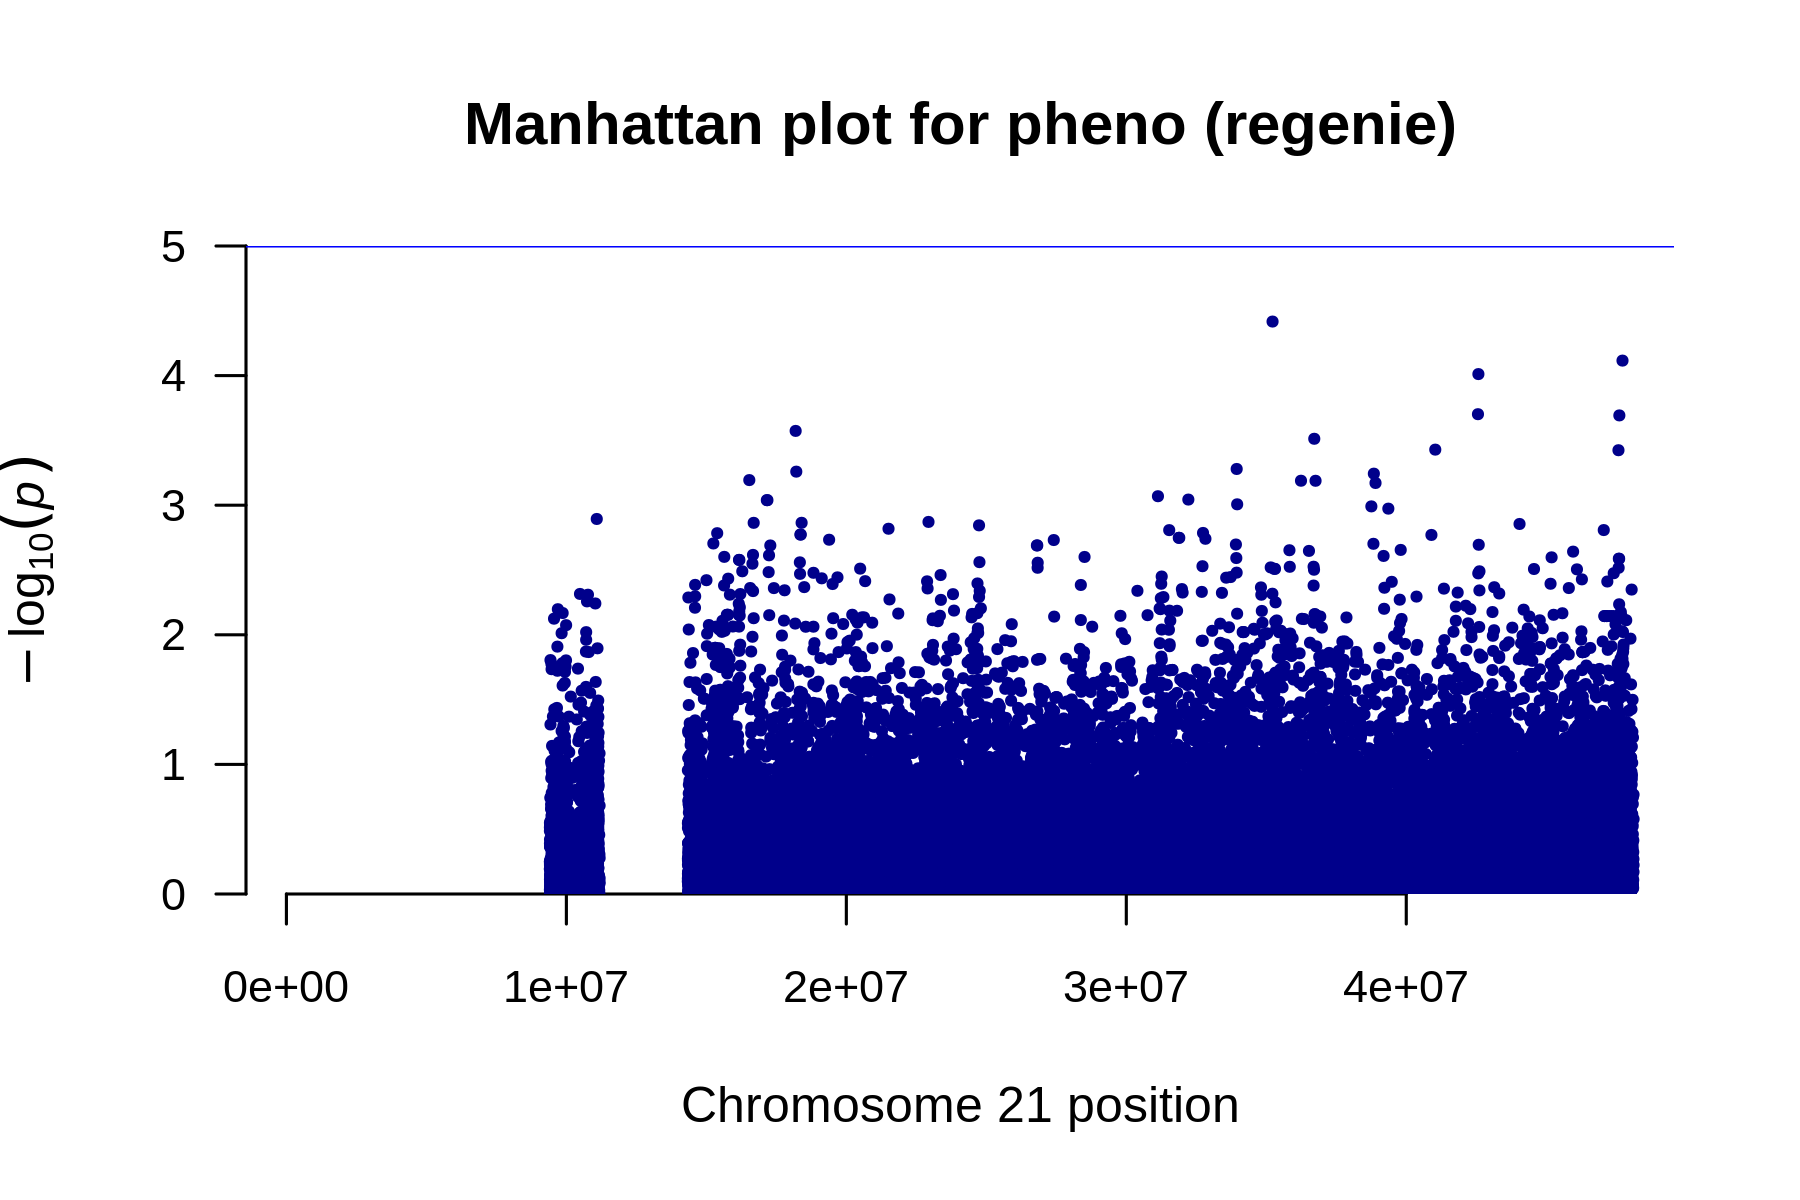

In [2]:
%preview output/1000G.EUR_pheno.regenie.manhattan.png

### Q-Q plot

> output/1000G.EUR_pheno.regenie.qq.png (73.7 KiB):

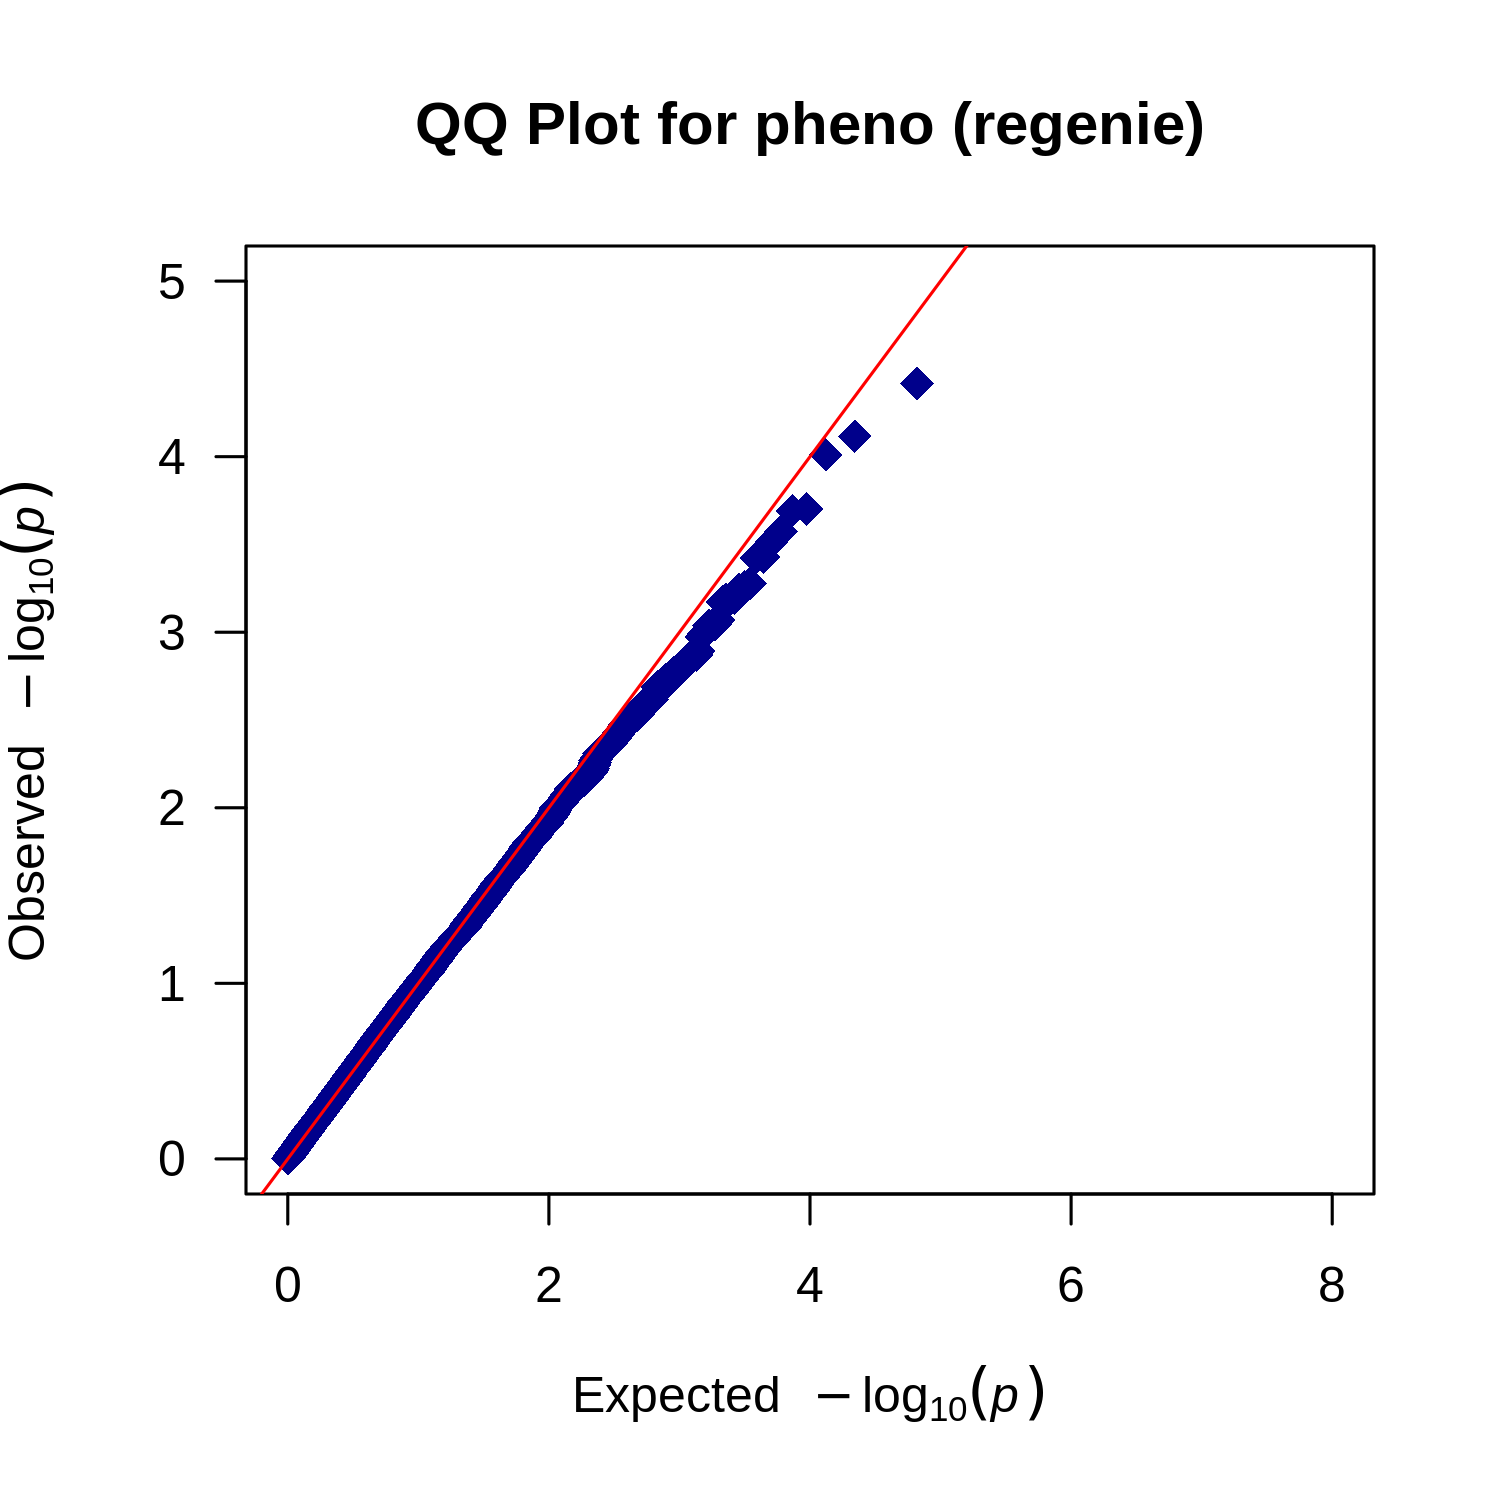

In [3]:
%preview output/1000G.EUR_pheno.regenie.qq.png

**Question:** What is the inflation (lambda GC) value for this run? 


### Lambda GC value

You can get a general idea of the number or cases/controls, the number of variants analyzed and the lambda GC values by taking a look at the markdown file generated in the `output` folder. 

In [4]:
cat output/1000G.EUR_pheno.regenie.analysis_summary.md

---
theme: base-theme
style: |
  img {
    height: 80%;
    display: block;
    margin-left: auto;
    margin-right: auto;
  }
---    

# pheno result summary
## Phenotype summary:
```
"Freq"
"n_ctrl" 249
"n_case" 240
```
## p-value summary:
Genomic inflation factor is 1.015 for 32986 variants analyzed.

---

# QQ plot for pheno

![](1000G.EUR_pheno.regenie.qq.png)

---

# Manhattan plot for pheno

![](1000G.EUR_pheno.regenie.manhattan.png)

---

# Result files
```
/home/jovyan/work/output/1000G.EUR_pheno.regenie.analysis_summary.md
/home/jovyan/work/output/1000G.EUR_pheno.regenie.log
/home/jovyan/work/output/1000G.EUR_pheno.regenie.manhattan.png
/home/jovyan/work/output/1000G.EUR_pheno.regenie.manhattan.stderr
/home/jovyan/work/output/1000G.EUR_pheno.regenie.manhattan.stdout
/home/jovyan/work/output/1000G.EUR_pheno.regenie.qq.png
/home/jovyan/work/output/1000G.EUR_pheno.regenie.snp_counts.txt
/home/jovyan/work/output/1000G.EUR_pheno.regenie.snp_stats.gz
/home/jovyan/work/output/1000G.

# Rare variant aggregate tests

The advancement and availability of feasible sequencing technologies provide a rich opportunity to study the association between rare/low frequency variants and complex traits. 
Rare variants (minor allele frequencies (MAFs) of less than 0.01) might play an important role in the etiology of complex traits and account for missing heritability unexplained by common variants ([Bodmer W et.al 2008](https://pubmed.ncbi.nlm.nih.gov/18509313/), [Schork N.J et.al 2009](https://pubmed.ncbi.nlm.nih.gov/19481926/) and [Manolio TA et.al 2009](https://www.nature.com/articles/nature08494)).

Gene-based or aggregate tests are recommended since individual rare variants have very low frequencies and limited statistical power when analyzed individually. Single-variant tests are typically conducted to investigate associations of common variants and phenotypes; however the same approach has little power when testing for rare-variant effects because of their low frequencies and the need of larger sample sizes. Instead, the statistical development of rare-variant analysis has been focused on testing cumulative effects of rare variants in genetic regions or SNP sets, such as genes. These tests can be broadly classified as burden and nonburden tests.

In recent years, significant efforts have been devoted to developing powerful and computationally efficient statistical methods for testing associations between rare variants and complex traits. Here are some common gene-based association tests for rare variants:

Instead of testing single variants for association with a phenotype, multiple variants can be aggregated within a region (e.g. gene) using the following model

$$g(\mu) = w_1G_1\beta_1\, +\, ... +\, w_mG_m\beta_m $$ 

where $G_i$'s represents the single variants included in the test, $w_i$'s and $\beta_i$'s are are the weights and the effect sizes, respectively, for each variant and $g(.)$ is a link function for the phenotypic mean $\mu$.

In regenie the collapsing approach by SAIGE-GENE+ has been implemented to aggregate ultra rare variants into a mask. 

**1. Burden Tests**

Burden tests, are fixed effect tests, that combine the effects of rare variants within a gene into a single test statistic. Different burden tests include the "collapsing" approach (combining individual variant p-values) and the "summarized" approach (summing variant effects within a gene). Because all burden tests implicitly assume that all the rare variants in a region are causal and affect the phenotype in the same direction with similar magnitudes, they suffer from a substantial loss of power when these assumptions are violated.
References: [Leal SM et.al 2008](https://pubmed.ncbi.nlm.nih.gov/18691683/), [Browning S.R et.al 2009](https://pubmed.ncbi.nlm.nih.gov/19214210/), [Zeggini E et.al 2010](https://pubmed.ncbi.nlm.nih.gov/19810025/).

In regenie the burden test is as defined in Lee et al 2014, which assumes $\beta_i = \beta \, \forall_i$, where $\beta$ is a fixed coefficient and leads to the test statistic



$$ Q_{burden} = \left( \sum_{i} \, w_i S_i \right)^2 $$

This test collapses variants into one single variable that is then tested for association with the phenotype. There are multiple ways variants can be aggregate into masks explained in the section under `regenie: burden test`, however, the default way is to take the maximum number of rare alleles across all the variant sites within a region. The variants as shown in the formula above can also be weighted by allele frequencies or annotation.

**2. Variance component tests**

* **SKAT (Sequence Kernel Association Test)** [Lin X et.al 2011](https://pubmed.ncbi.nlm.nih.gov/21737059/)
 
Instead of aggregating variants, SKAT aggregates individual variant-score test statistics with weights when SNV effects are modeled linearly. More generally, SKAT aggregates the associations between variants and the phenotype through a kernel matrix and can allow for SNV-SNV interactions, i.e., epistatic effects. SKAT is especially powerful when a genetic region has both protective and deleterious variants or many noncausal variants. It can be less powerful than burden tests if a large proportion of the rare variants in a region are truly causal and influence the phenotype in the same direction. In addition, large-sample-based p-value calculations, which SKAT uses, can produce conservative type I errors for small-sample case-control sequencing association studies, which could lead to a loss in power. 

SKAT assumes that effect sizes $\beta_i$ come from an arbitrary distribution with mean 0 and variance $\tau^2$, leading to the test statistic:


$$ Q_{SKAT} =  \sum_{i} \, w_i^2 S_i^2  $$

* **SKAT-O (Sequence Kernel Association Combined Test)** [Lin X et.al 2012](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3415556/)

SKAT-O is an extension of SKAT that combines SKAT and the burden test. It allows for the flexibility of both kernel-based and collapsing approaches and provides a combined test statistic.

  $$
  Q_{\text{SKATO}}=\rho Q_{\text{BURDEN}}+(1-\rho)Q_{\text{SKAT}}
  $$


Therefore, setting $\rho=0$ corresponds to a SKAT test and $\rho=1$ corresponds to a burden test. The parameter $\rho$ is used to maximize power. Regenie uses a default grid of 8 values {${ 0.1^2,0.2^2, 0.3^2, 0.4^2, 0.5^2, 0.5,1}$} and sets the weight as $w_i= \beta(MAF_i,1,25)$.

Regenie allows for testing other types of aggregate tests such as SKATO-ACAT, ACATV, ACATO, and ACATO-FULL. Please refer to [regenie's tutorial](https://rgcgithub.github.io/regenie/overview/#step-2-gene-based-testing) for more details about these tests.

# Packages/Software

There are several R packages available to run gene-based association tests for rare variants that can be implemented in different programs like [regenie](https://rgcgithub.github.io/regenie/options/#skatacat-tests) and [GMMAT](https://cran.r-project.org/web/packages/GMMAT/vignettes/GMMAT.pdf)

This particular gene-based analysis pipline is based on **regenie**. Regenie can apply various set-based tests on the variants as well as collapse them into a single combined 'mask' genotype that can be tested for association just like a single (mega) variant. For example, the option `--vc-tests` is used to specify the SKAT and ACAT tests and the p-values for SKAT, SKATO, ACATV and ACATO will be outputted.
For the details see the documentation here [regenie](https://rgcgithub.github.io/regenie/options/#skatacat-tests).

**NOTE**: Proper data preprocessing, variant annotation, and quality control are essential steps before conducting rare-variant aggregate tests.

## 2. Regenie : burden test

Regenie offers the functionality of performing rare-variant aggregate association analysis. 

You can combine rare-variants in a gene or a region, using functional annotations to create masks that are then tested for association (as in a single variant analysis) with a phenotype. 

### Input files

1. You will need to provide an `annotation file` that is formatted: variant_id, gene/region, functional annotation (e.g. LoF, missense). You can use VEP or ANNOVAR to generate this information and then format it accordingly. 
2. Provide the `set-list-file`: this file contains a list of variants within each gene/region that's used when building the masks. The format is: gene/region name, chromosome, start_position, list of variants in the gene/region separated by comma. 
3. Optional: provide a file with genes/regions that you want to include or exclude from your analysis.
4. Optional: provide an `allele-frequency` file to use when creating the masks. By default the allele frequency is computed from the sample. In our case we are providing an allele-frequency file, obtained from gnomAD exome frequencies. We will use the AF_nfe field which contains the allele frequencies from exome data for non Finnish Europeans available in gnomAD. 
5. Mask file: this is a text file that contains the name of the mask and the type of annotations to use when building it (one mask per line). E.g. 

```
mask1 LoF,missense
```

6. You need to provide the `--aaf-bins` cut-off in the parameters. This refers to the AAF upper bounds to use when creating the masks. By default regenie_burden produces results for singletons and if you set `--aaf-bins` to be for example 0.01 it will create masks from  [0,0.01] and singletons. 

Additionally, you can choose the way the mask are built. These options are:
- using the maximum number of ALT alleles across sites ('max'; the default)
- using the sum of ALT alleles ('sum')
- using a maximum threshold of 2 ('comphet')

![Rules to build mask](https://rgcgithub.github.io/regenie/img/mask_rules.png)


For this MWE we have already generated the annotation, the set list, the allele frequency and the mask files that are provided in the `data` folder. 

### Regenie: burden test

### Command explanation

In addition to the commands there are some extra parameters that need to bet set for the burden tests:

* `anno-file`: is the path to the annotation file, which is required by regenie to run the burden analysis. Please refer to [regenie tutorial](https://rgcgithub.github.io/regenie/options/#annotation-input-files) to learn more
* `aaf_file`: is the path to the allele frequency file, which is required by regenie to run the burden analysis. Please refer to [regenie tutorial](https://rgcgithub.github.io/regenie/options/#annotation-input-files) to learn more
* `set_list`: is the path to set list file, which is required by regenie to run the burden analysis. Please refer to [regenie tutorial](https://rgcgithub.github.io/regenie/options/#annotation-input-files) to learn more
* `mask_file`: corresponds to the mask_file path. Please refer to [regenie tutorial](https://rgcgithub.github.io/regenie/options/#annotation-input-files) to learn more
* `build_mask`: parameter indicates the way that the mask should be created (max, sum and comphet). Please refer to [regenie tutorial](https://rgcgithub.github.io/regenie/options/#annotation-input-files) to learn more 
* `aaf_bins`: refers to the alternative allele frequency (AAF) upper bounds to use when creating the masks. In this example `0.01` will be used

In [6]:
sos run regenie.ipynb regenie_burden \
    --cwd output_burden \
    --bfile regenie_statgen_mwe/1000G.EUR.mwe.pruned.bed \
    --maf-filter 0.01 \
    --geno-filter 0.1 \
    --mind-filter 0.1 \
    --hwe_filter 5e-08 \
    --genoFile regenie_statgen_mwe/1000G.EUR.mwe.chr21-22.step2.regenie.qc.bed \
    --phenoFile regenie_statgen_mwe/1000G.EUR.pheno \
    --formatFile regenie_statgen_mwe/regenie_template.yml \
    --phenoCol pheno \
    --covarCol sex \
    --qCovarCol PC1 PC2 \
    --chrList '21' \
    --numThreads 8 \
    --bsize 1000 \
    --trait bt \
    --minMAC 1 \
    --reverse_log_p \
    --anno_file regenie_statgen_mwe/1000G.EUR.hg19.hg19_multianno.csv.anno_file \
    --aaf_file regenie_statgen_mwe/1000G.EUR.hg19.hg19_multianno.csv.aff_file \
    --set_list regenie_statgen_mwe/1000G.EUR.hg19.hg19_multianno.csv.set_list_file\
    --mask_file regenie_statgen_mwe/1000G.EUR.mask_file \
    --build_mask max \
    --aaf_bins  0.01

INFO: Running regenie_qc: Select the SNPs and samples to be used based on maf, geno, hwe and mind options
INFO: regenie_qc is completed.
INFO: regenie_qc output:   /home/jovyan/work/output_burden/cache/1000G.EUR.mwe.pruned.qc_pass.id /home/jovyan/work/output_burden/cache/1000G.EUR.mwe.pruned.qc_pass.snplist
INFO: Running regenie_burden_1: Run REGENIE step 1: fitting the null
INFO: regenie_burden_1 is completed.
INFO: regenie_burden_1 output:   /home/jovyan/work/output_burden/1000G.EUR_pheno.regenie_pred.list
INFO: Running regenie_burden_2: Run regenie for rare variant aggregate tests
INFO: regenie_burden_2 is completed.
INFO: regenie_burden_2 output:   /home/jovyan/work/output_burden/1000G.EUR.mwe.chr21-22.step2.regenie.qc_rarevariant_pheno.regenie.gz
INFO: Running regenie_burden_3: 
INFO: regenie_burden_3 is completed.
INFO: regenie_burden_3 output:   /home/jovyan/work/output_burden/cache/1000G.EUR.mwe.chr21-22.step2.regenie.qc_rarevariant_pheno.regenie_pheno_mask1.singleton.regenie.g

### Output files

After running regenie burden you will find the following output files in the `output_burden` folder:

* `1000G.EUR.mwe.step2.regenie.qc_rarevariant_pheno.regenie.gz` This file contains the results only for mask1 and 0.01 bin
* `1000G.EUR_pheno.regenie_burden.mask1.0.01.manhattan.png` Manhattan pot
* `1000G.EUR_pheno.regenie_burden.mask1.0.01.qq.png` Q-Q plot
* `1000G.EUR_pheno.regenie_burden.mask1.0.01.analysis_summary.md` Markdown file with summarized information

Now let's visualize the results of the association. You can see that manhattan and q-q plots have been generated for mask1 with the 0.01 bin combination. 

### Manhattan plot

> output_burden/1000G.EUR_pheno.regenie_burden.mask1.0.01.manhattan.png (68.1 KiB):

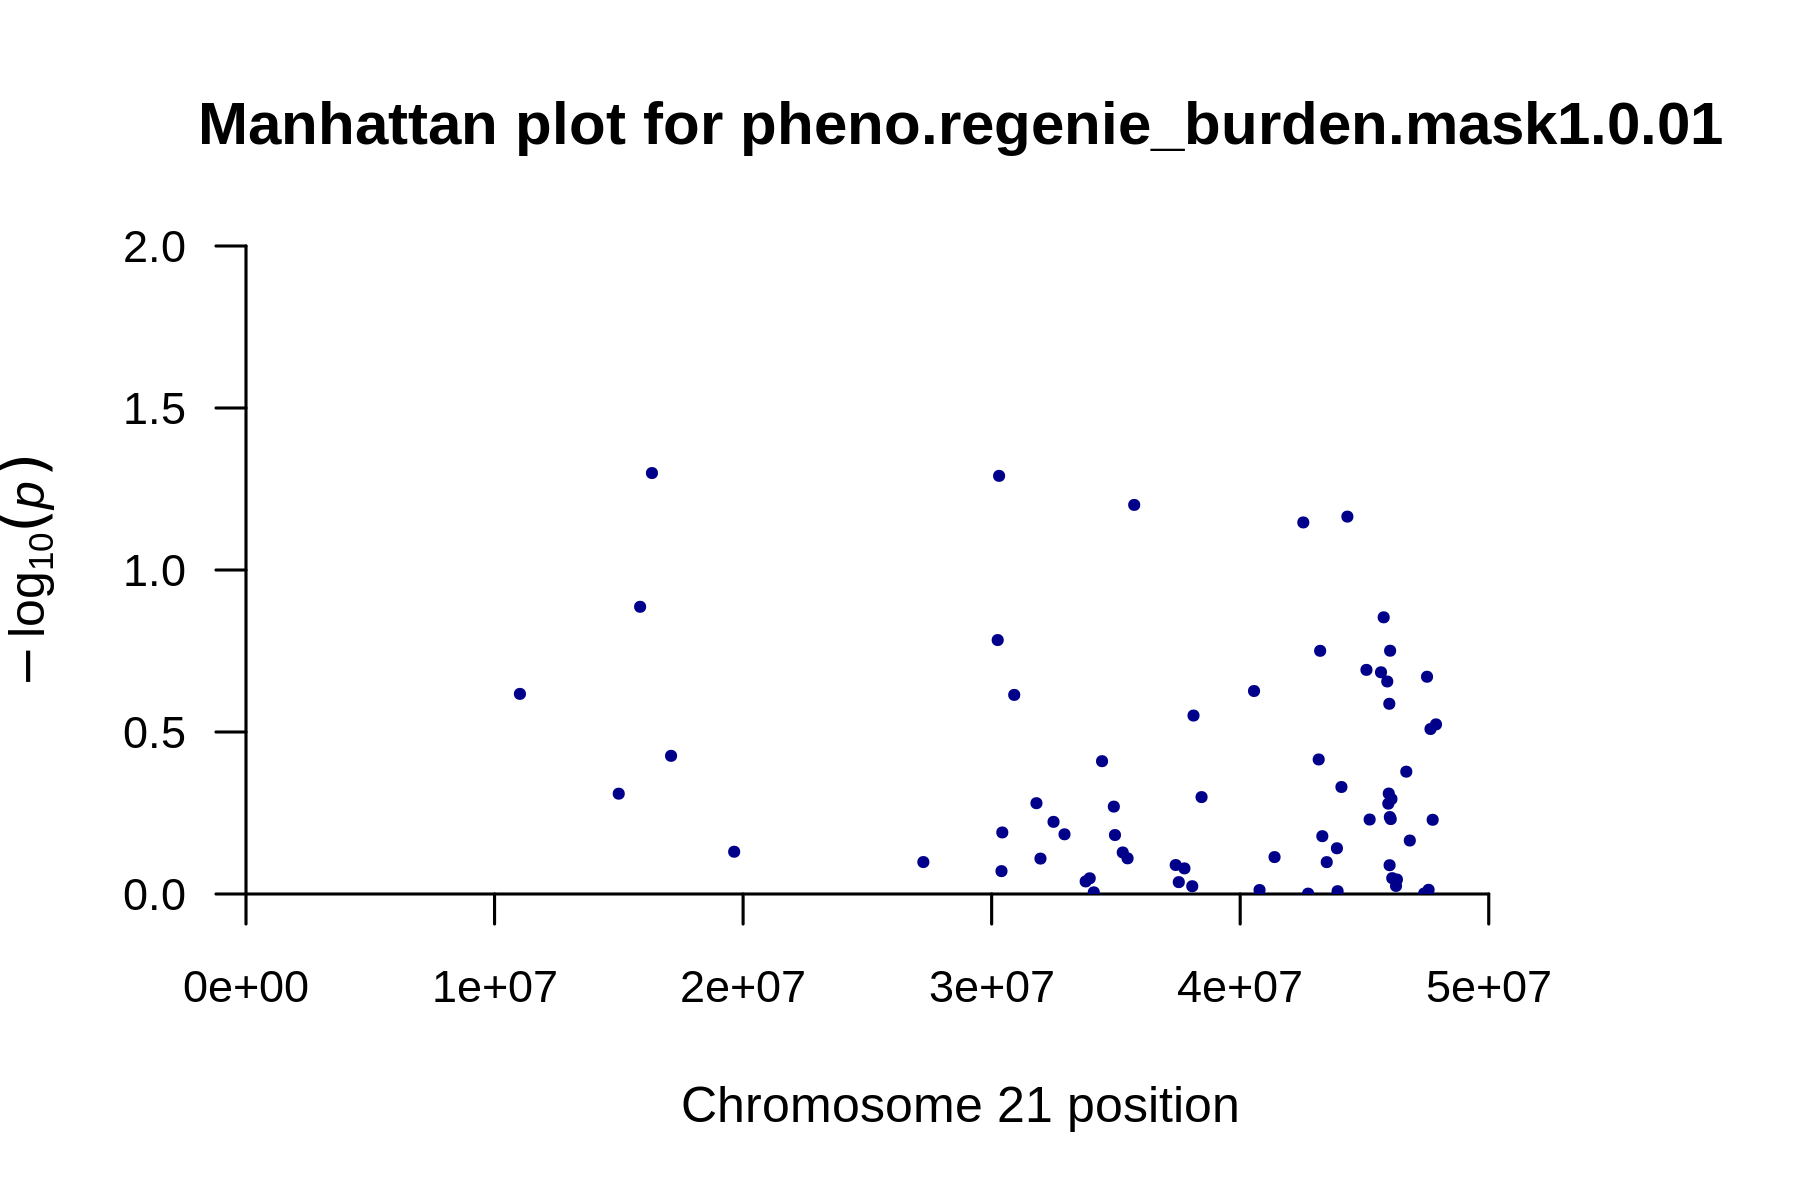

In [7]:
%preview output_burden/1000G.EUR_pheno.regenie_burden.mask1.0.01.manhattan.png

### Q-Q plot

> output_burden/1000G.EUR_pheno.regenie_burden.mask1.0.01.qq.png (74.9 KiB):

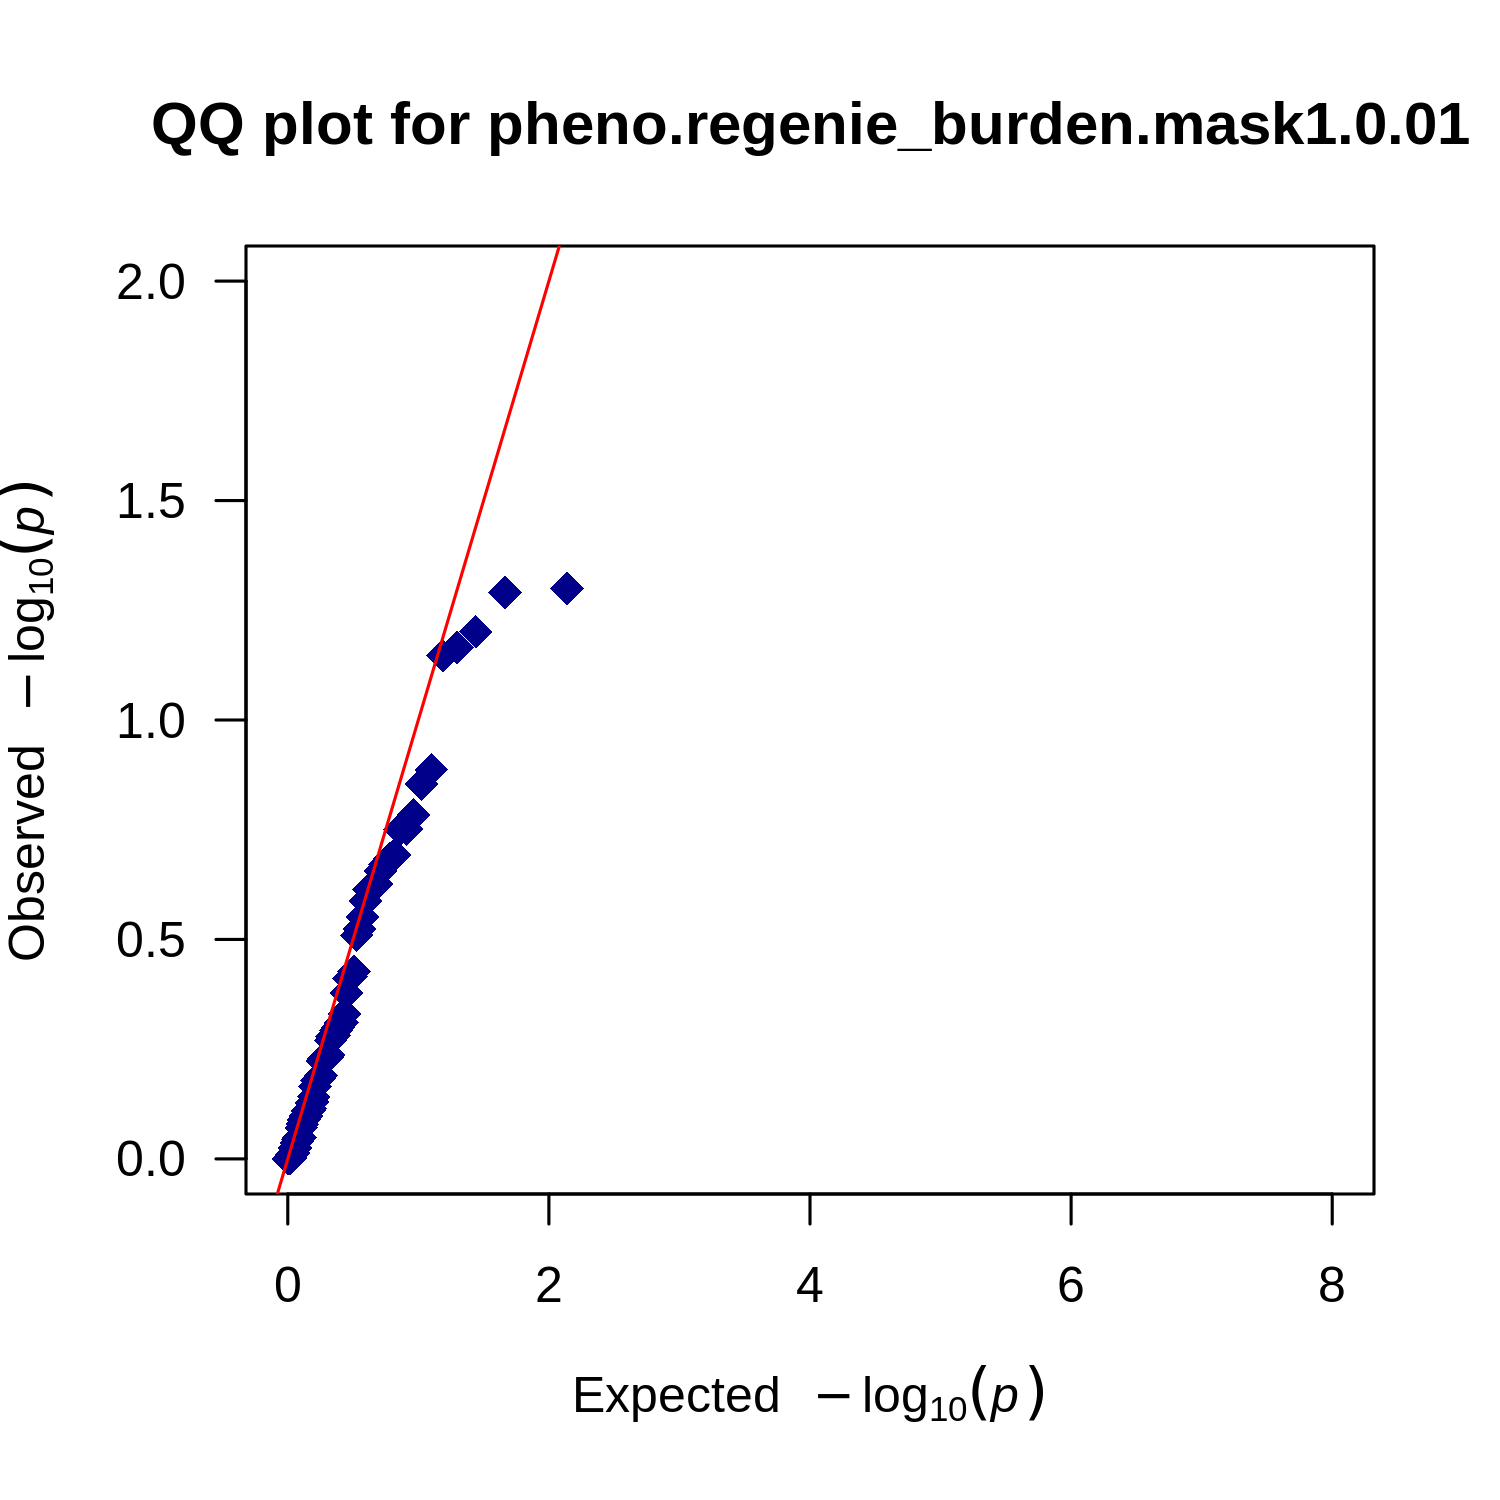

In [8]:
%preview output_burden/1000G.EUR_pheno.regenie_burden.mask1.0.01.qq.png

### Analysis summary

In [9]:
cat output_burden/1000G.EUR_pheno.regenie_burden.mask1.0.01.analysis_summary.md

---
theme: base-theme
style: |
  img {
    height: 80%;
    display: block;
    margin-left: auto;
    margin-right: auto;
  }
---    

# pheno.regenie_burden.mask1.0.01 result summary
## Phenotype summary:
```
"Freq"
"n_ctrl" 249
"n_case" 240
```
## p-value summary:
Genomic inflation factor is 0.648 for 69 genes analyzed.

---

# QQ plot for 1000G.EUR_pheno.regenie_burden.mask1.0

![](1000G.EUR_pheno.regenie_burden.mask1.0.01.qq.png)

---

# Manhattan plot for 1000G.EUR_pheno.regenie_burden.mask1.0

![](1000G.EUR_pheno.regenie_burden.mask1.0.01.manhattan.png)

---

# Result files
```
/home/jovyan/work/output_burden/1000G.EUR_pheno.regenie_burden.mask1.0.01.analysis_summary.md
/home/jovyan/work/output_burden/1000G.EUR_pheno.regenie_burden.mask1.0.01.manhattan.png
/home/jovyan/work/output_burden/1000G.EUR_pheno.regenie_burden.mask1.0.01.qq.png
/home/jovyan/work/output_burden/1000G.EUR_pheno.regenie_burden.mask1.0.01.snp_counts.txt
/home/jovyan/work/output_burden/1000G.EUR_pheno.regenie_

### Question

What is the lambda GC for the regenie burden analysis? 

How many genes were included in the analysis?

### Answer

You can take a look at the markdown file and notice that the lambda GC for this analysis is:0.648 and 69 genes were analyzed

# 3. Regenie: SKAT-O test

In regenie 3.0 new methods to perform rare variant aggregate tests have been added. More specifically, for a given set of variants (e.g. within a gene) which can be defined using functional annotations, regenie can apply various set-based tests:

* SKAT: Variance component test
* SKAT-O: Omnibus test combining features of SKAT and Burden
* SKATO-ACAT: Same as SKATO but using Cauchy combination method to maximize power across SKATO models
* ACATV:  Test using Cauchy combination method to combine single-variant p-values
* ACATO: Omnibus test combining features of ACATV, SKAT and Burden
* ACATO-FULL: Same as ACATO but using the larger set of SKATO models used in the SKATO test

If you would like to include variants only under a given threshold allele frequency threshold (rare or ultrarare variants) you should define the parameter `--vc-maxAAF` or `--vc-MACthr` to set a MAC threshold under which all the variants will be considered in the analysis. 


### Input files

The input files are the same to those used in the burden test

### Command explanation

In addition to the commands explained above, there are two more parameters that need to be set for the skat tests. 

* `vc_tests`: used to specify the gene-based tests to run (e.g skat, skato, acato, etc)
* `vc_maxAAF`: is used to include variants whose alternative allele frequency (AAF) is below a given threshold
* `vc_tests_reg`: is used during the manhattan and q-q plot generation, to indicate which plots you would like to generate depending on the tests run in regenie step 2

In [10]:
sos run regenie.ipynb regenie_vc \
    --cwd output_vc \
    --bfile regenie_statgen_mwe/1000G.EUR.mwe.pruned.bed \
    --maf-filter 0.01 \
    --geno-filter 0.1 \
    --mind-filter 0.1 \
    --hwe_filter 5e-08 \
    --genoFile regenie_statgen_mwe/1000G.EUR.mwe.chr21-22.step2.regenie.qc.bed \
    --phenoFile  regenie_statgen_mwe/1000G.EUR.pheno \
    --formatFile regenie_statgen_mwe/regenie_vc_template.yml \
    --phenoCol pheno \
    --covarCol sex \
    --qCovarCol PC1 PC2\
    --chrList '21' \
    --numThreads 8 \
    --bsize 1000 \
    --trait bt \
    --minMAC 1 \
    --reverse_log_p \
    --anno_file regenie_statgen_mwe/1000G.EUR.hg19.hg19_multianno.csv.anno_file \
    --aaf_file regenie_statgen_mwe/1000G.EUR.hg19.hg19_multianno.csv.aff_file \
    --set_list regenie_statgen_mwe/1000G.EUR.hg19.hg19_multianno.csv.set_list_file \
    --mask_file regenie_statgen_mwe/1000G.EUR.mask_file \
    --build_mask max\
    --vc_tests skato\
    --vc_tests_reg ADD-SKAT ADD-SKATO \
    --vc_maxAAF 0.01 \
    --aaf_bins  0.01 

INFO: Running regenie_qc: Select the SNPs and samples to be used based on maf, geno, hwe and mind options
INFO: regenie_qc is completed.
INFO: regenie_qc output:   /home/jovyan/work/output_vc/cache/1000G.EUR.mwe.pruned.qc_pass.id /home/jovyan/work/output_vc/cache/1000G.EUR.mwe.pruned.qc_pass.snplist
INFO: Running regenie_vc_1: Run REGENIE step 1: fitting the null
INFO: regenie_vc_1 is completed.
INFO: regenie_vc_1 output:   /home/jovyan/work/output_vc/1000G.EUR_pheno.regenie_pred.list
INFO: Running regenie_vc_2: Run regenie for rare variant aggregate tests
INFO: regenie_vc_2 is completed.
INFO: regenie_vc_2 output:   /home/jovyan/work/output_vc/1000G.EUR.mwe.chr21-22.step2.regenie.qc_rarevariant_pheno.regenie.gz
INFO: Running regenie_vc_3: 
INFO: regenie_vc_3 is completed.
INFO: regenie_vc_3 output:   /home/jovyan/work/output_vc/cache/1000G.EUR.mwe.chr21-22.step2.regenie.qc_rarevariant_pheno.regenie_pheno_mask1.singleton.regenie.gz /home/jovyan/work/output_vc/cache/1000G.EUR.mwe.chr21-

### Output files

After running regenie skato you will find these relevant output files in the `output_vc` folder:

- This file contains the merged results for skat, skato and also the additive univariate test for each variant
`1000G.EUR_pheno.regenie_vc.snp_stats.gz`
- This file contains only the results for the score test for SKAT
`1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKAT.snp_stats.gz`
- This file contains only the results for the score test for SKATO
`1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKATO.snp_stats.gz`
- The manhattan plot for the SKATO
`1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKAT.manhattan.png`
- The qq plot for the SKATO
`1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKAT.qq.png`
- The summary of the analysis for the SKATO
`1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKATO.analysis_summary.md`
- The manhattan plot for the SKAT 
`1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKAT.manhattan.png`
- The qq plot for the SKAT
`1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKAT.qq.png`
- The summary of the analysis for the SKAT
`1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKAT.analysis_summary.md`

### Manhattan and q-q plots for SKAT and SKAT-O

> output_vc/1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKAT.manhattan.png (71.7 KiB):

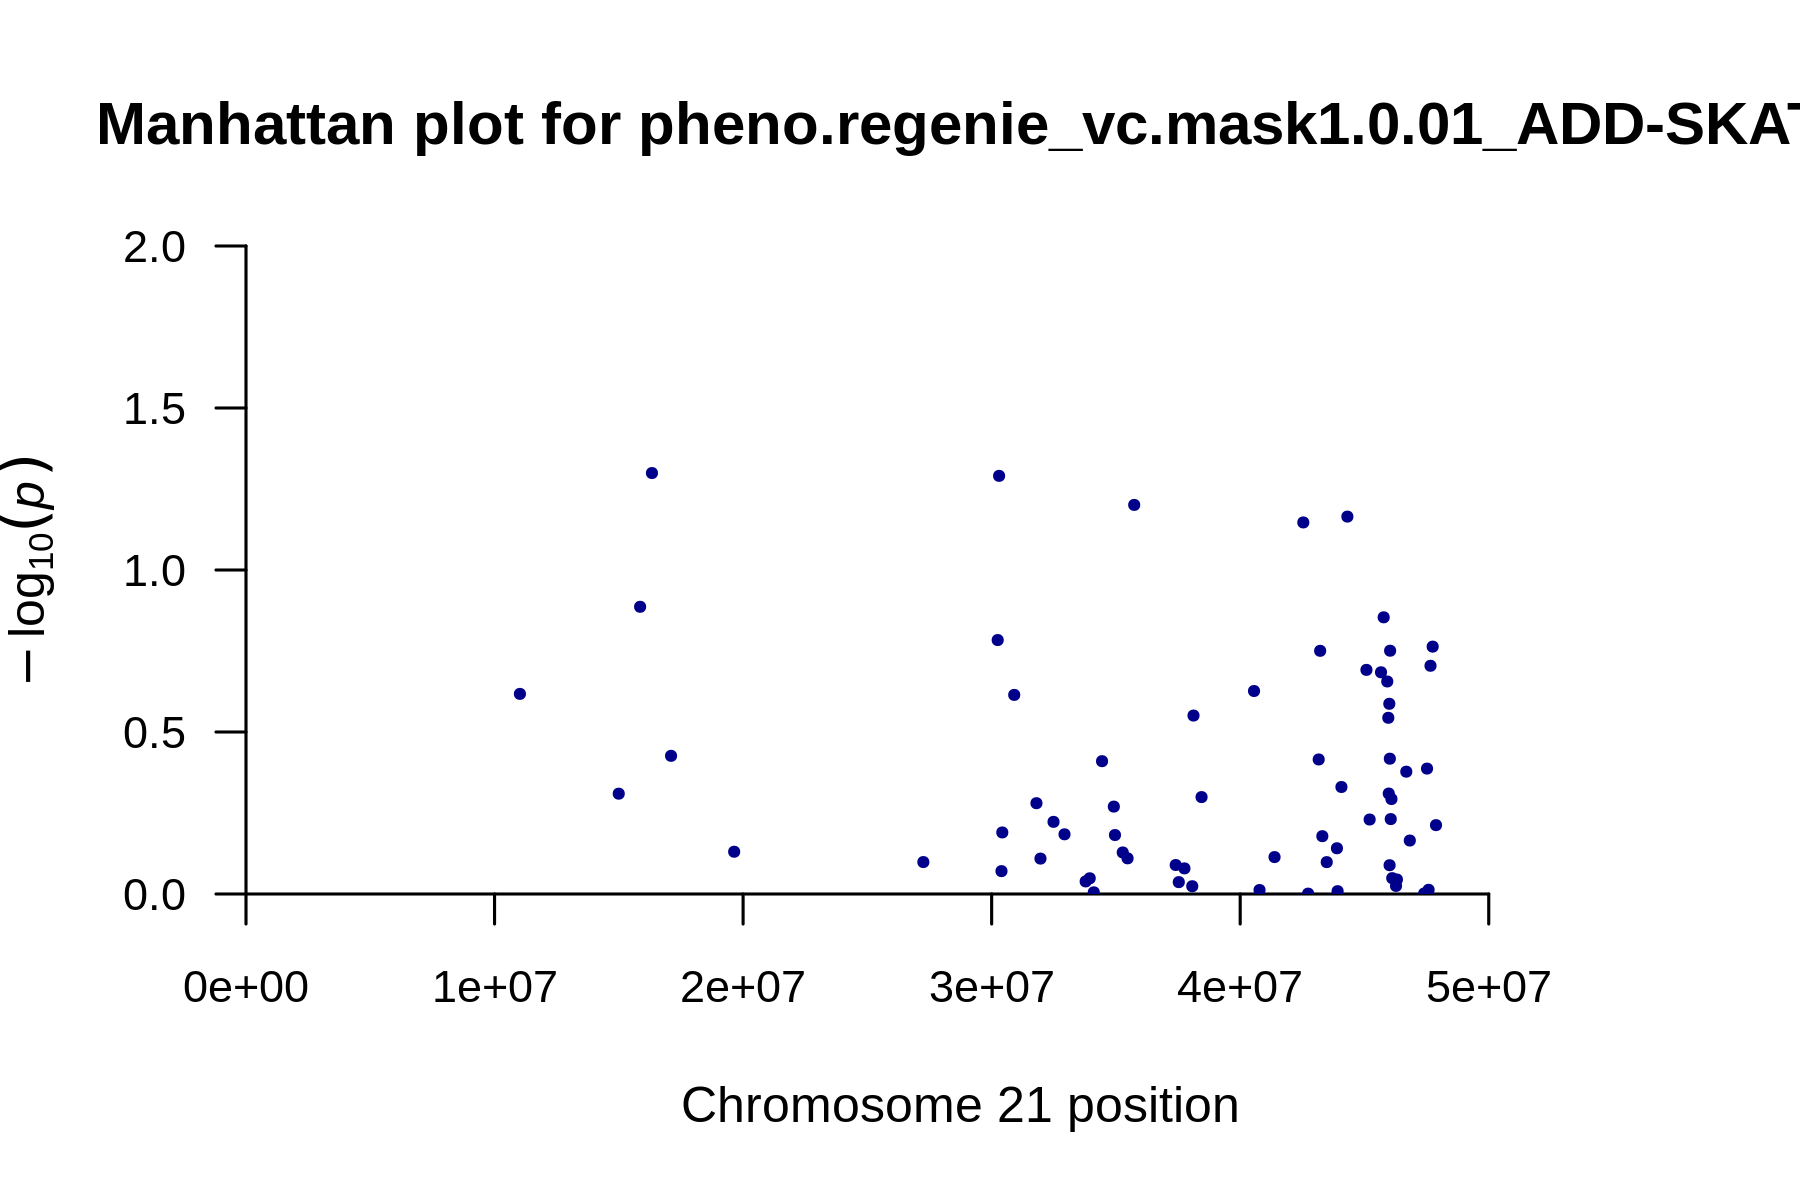

In [11]:
%preview output_vc/1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKAT.manhattan.png

> output_vc/1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKAT.qq.png (77.5 KiB):

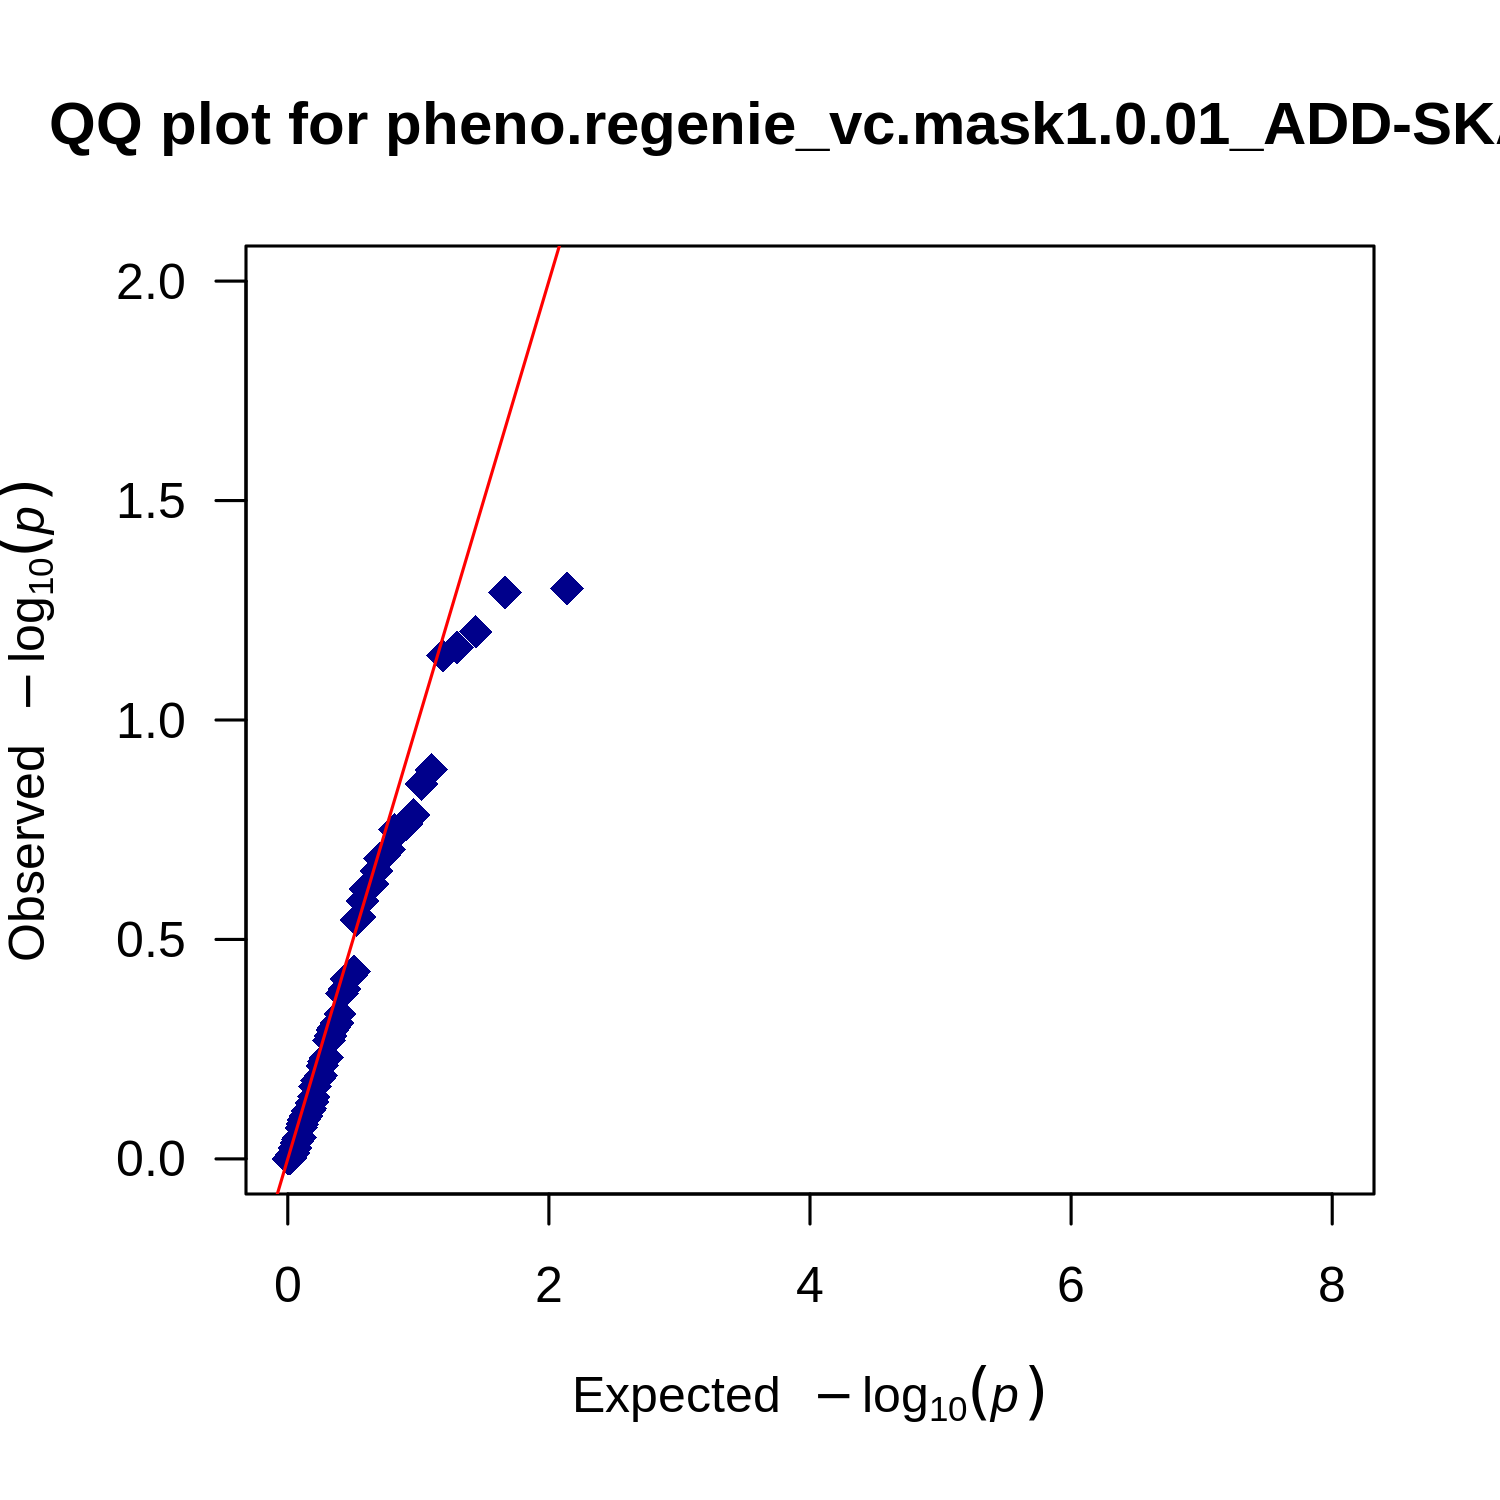

In [12]:
%preview output_vc/1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKAT.qq.png

In [13]:
cat output_vc/1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKAT.analysis_summary.md

---
theme: base-theme
style: |
  img {
    height: 80%;
    display: block;
    margin-left: auto;
    margin-right: auto;
  }
---    

# pheno.regenie_vc.mask1.0.01_ADD-SKAT result summary
## Phenotype summary:
```
"Freq"
"n_ctrl" 249
"n_case" 240
```
## p-value summary:
Genomic inflation factor is 0.648 for 69 genes analyzed.

---

# QQ plot for 1000G.EUR_pheno.regenie_vc.mask1.0

![](1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKAT.qq.png)

---

# Manhattan plot for 1000G.EUR_pheno.regenie_vc.mask1.0

![](1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKAT.manhattan.png)

---

# Result files
```
/home/jovyan/work/output_vc/1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKAT.analysis_summary.md
/home/jovyan/work/output_vc/1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKAT.manhattan.png
/home/jovyan/work/output_vc/1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKATO.analysis_summary.md
/home/jovyan/work/output_vc/1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKATO.manhattan.png
/home/jovyan/work/output_vc/100

> output_vc/1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKATO.manhattan.png (71.3 KiB):

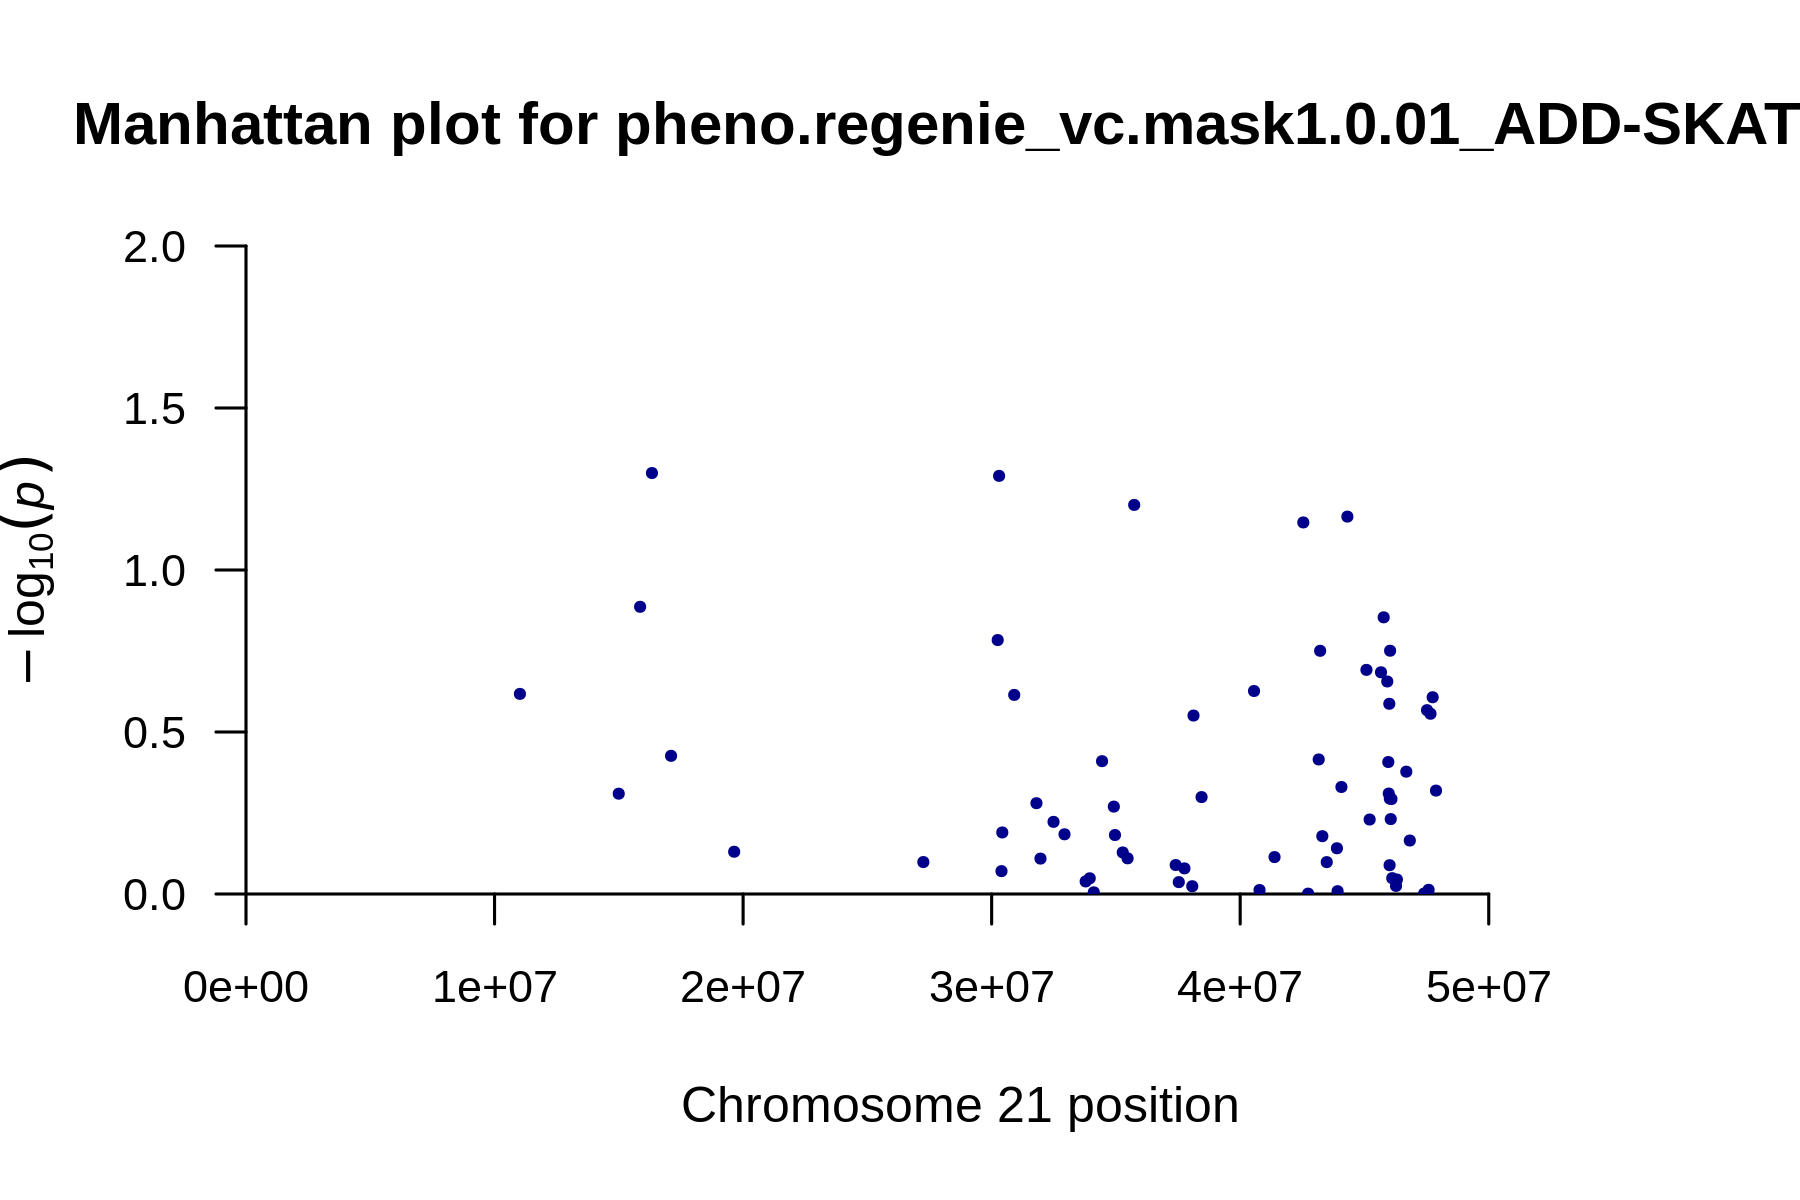

In [14]:
%preview -s png output_vc/1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKATO.manhattan.png

> output_vc/1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKATO.qq.png (77.5 KiB):

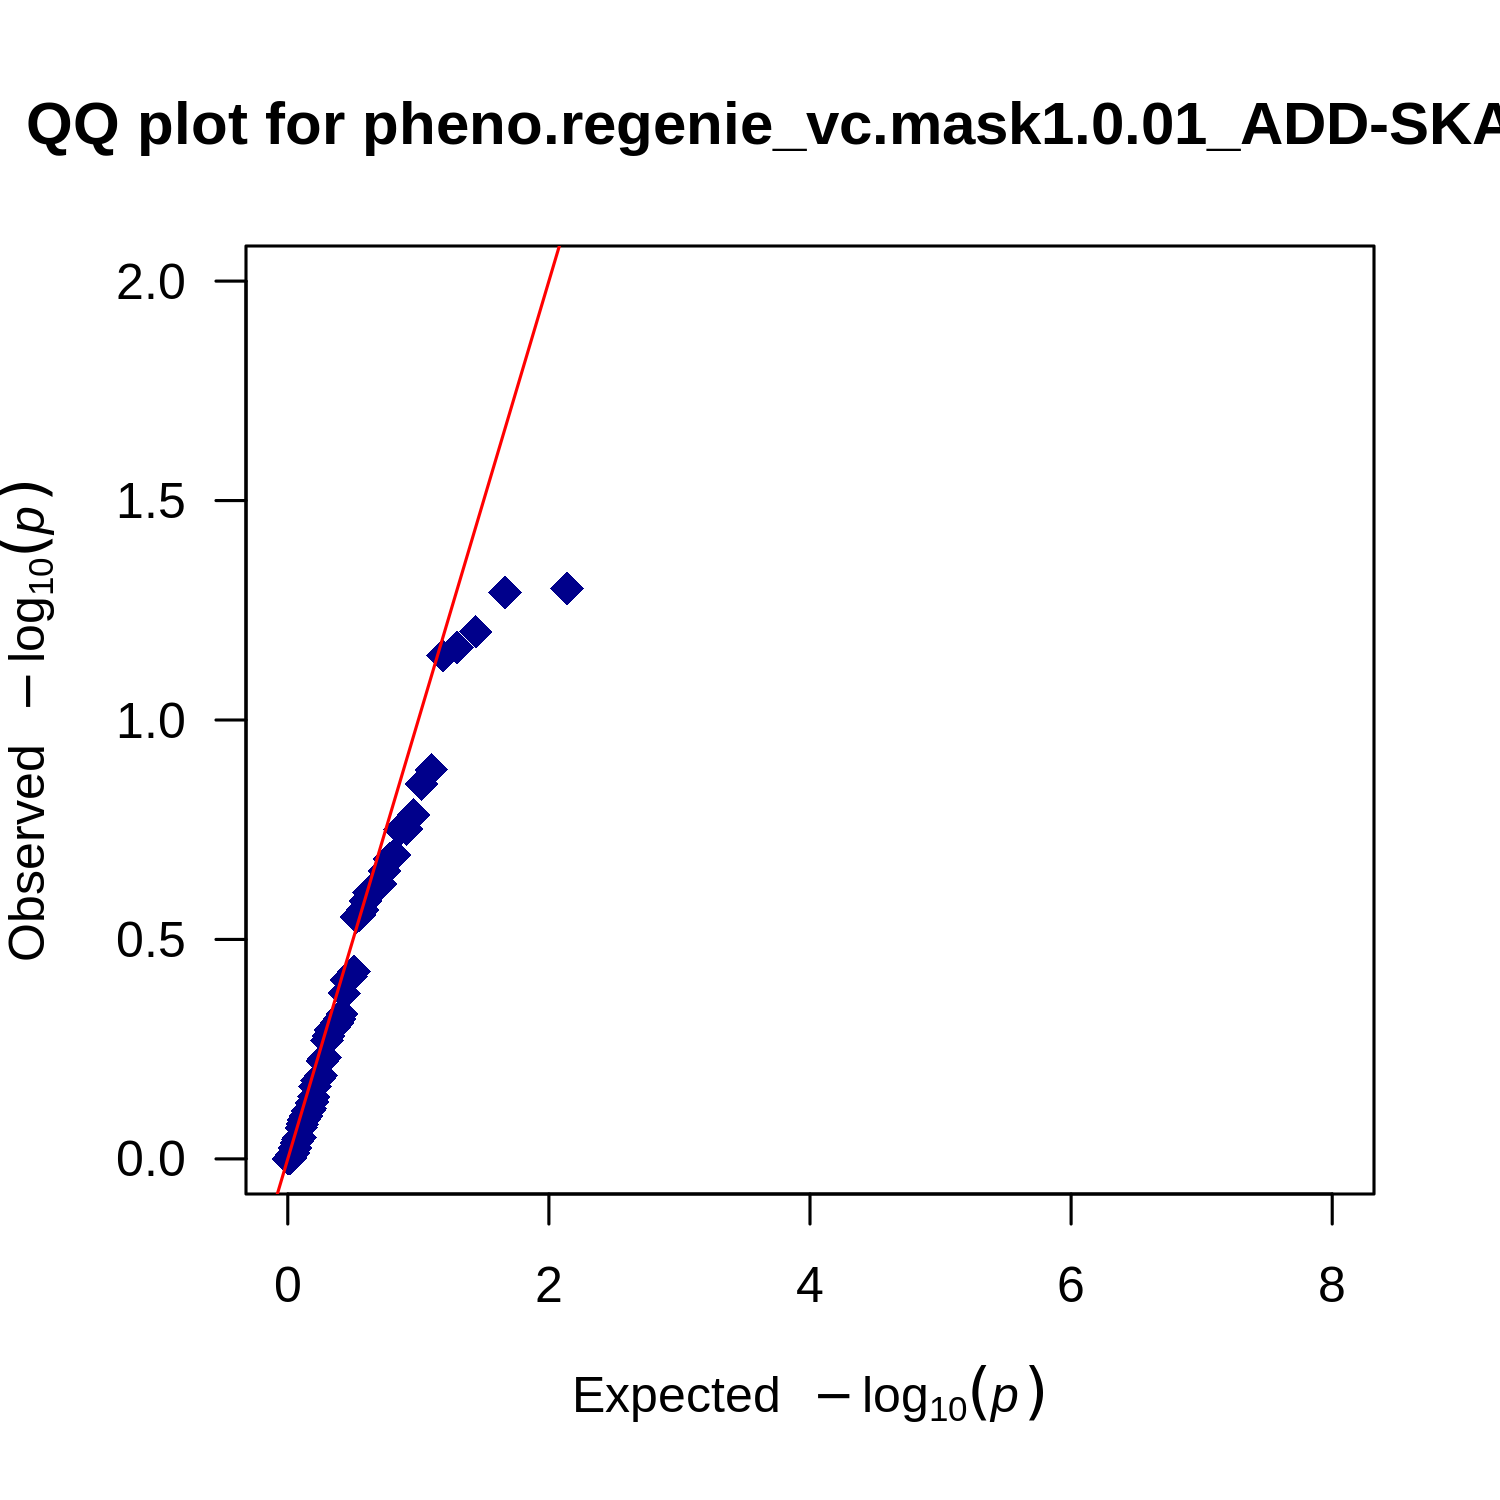

In [15]:
%preview -s png output_vc/1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKATO.qq.png

In [16]:
cat output_vc/1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKATO.analysis_summary.md

---
theme: base-theme
style: |
  img {
    height: 80%;
    display: block;
    margin-left: auto;
    margin-right: auto;
  }
---    

# pheno.regenie_vc.mask1.0.01_ADD-SKATO result summary
## Phenotype summary:
```
"Freq"
"n_ctrl" 249
"n_case" 240
```
## p-value summary:
Genomic inflation factor is 0.836 for 69 genes analyzed.

---

# QQ plot for 1000G.EUR_pheno.regenie_vc.mask1.0

![](1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKATO.qq.png)

---

# Manhattan plot for 1000G.EUR_pheno.regenie_vc.mask1.0

![](1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKATO.manhattan.png)

---

# Result files
```
/home/jovyan/work/output_vc/1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKAT.analysis_summary.md
/home/jovyan/work/output_vc/1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKAT.manhattan.png
/home/jovyan/work/output_vc/1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKATO.analysis_summary.md
/home/jovyan/work/output_vc/1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKATO.manhattan.png
/home/jovyan/work/output_vc/

### Questions

* How many genes did you analyze in each test?

* What's the lambda GC for SKAT? and for SKAT-O?

* What's the gene with the lowest p-value in SKAT and SKAT-O? Is it the same gene or a different one?

* Why are there no genome-wide significant tests?

**Additional exercise**

Perform the analysis again but this time using chromosome 22.

*Hint*: copy commands from above and change `chrList` to '22'

### Answers

* How many genes did you analyze in each test?

If you look into the markdown file you can see that the number of genes analyzed was 69 for both SKAT and SKAT-O

* What's the lambda GC for SKAT? and for SKAT-O?

Again, by looking into the markdown file you can see that the lambda GC for SKAT is 0.648 and for SKAT-O it is 0.836

* What's the gene with the lowest p-value in SKAT and SKAT-O? Is it the same gene or a different one?

You can take a look at the summary statistics to find the gene with the lowest p-value

In [17]:
zcat output_vc/1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKAT.snp_stats.gz | sort -k8 -n | head

CHR	POS	REF	ALT	SNP	TEST	CHISQ	P
21	16332923	ref	mask1.0.01	NRIP1.mask1.0.01	ADD-SKAT	3.83463	0.050204194102117
21	30299585	ref	mask1.0.01	LTN1.mask1.0.01	ADD-SKAT	3.801	0.051222409050966
21	35735461	ref	mask1.0.01	KCNE2.mask1.0.01	ADD-SKAT	3.4575	0.0629651148701626
21	44312517	ref	mask1.0.01	NDUFV3.mask1.0.01	ADD-SKAT	3.3204	0.0684258183294241
21	42539293	ref	mask1.0.01	BACE2.mask1.0.01	ADD-SKAT	3.25235	0.0713214230652586
21	15856974	ref	mask1.0.01	SAMSN1.mask1.0.01	ADD-SKAT	2.29389	0.1298841031783759
21	45772638	ref	mask1.0.01	TRPM2.mask1.0.01	ADD-SKAT	2.17825	0.1399735573193395
21	30243656	ref	mask1.0.01	N6AMT1.mask1.0.01	ADD-SKAT	1.93222	0.164516325157312
21	47744127	ref	mask1.0.01	PCNT.mask1.0.01	ADD-SKAT	1.86207	0.1723856060347658


In [18]:
zcat output_vc/1000G.EUR_pheno.regenie_vc.mask1.0.01_ADD-SKATO.snp_stats.gz | sort -k8 -n | head

CHR	POS	REF	ALT	SNP	TEST	CHISQ	P
21	16332923	ref	mask1.0.01	NRIP1.mask1.0.01	ADD-SKATO	3.83463	0.050204194102117
21	30299585	ref	mask1.0.01	LTN1.mask1.0.01	ADD-SKATO	3.801	0.051222409050966
21	35735461	ref	mask1.0.01	KCNE2.mask1.0.01	ADD-SKATO	3.4575	0.0629651148701626
21	44312517	ref	mask1.0.01	NDUFV3.mask1.0.01	ADD-SKATO	3.3204	0.0684258183294241
21	42539293	ref	mask1.0.01	BACE2.mask1.0.01	ADD-SKATO	3.25235	0.0713214230652586
21	15856974	ref	mask1.0.01	SAMSN1.mask1.0.01	ADD-SKATO	2.29389	0.1298841031783759
21	45772638	ref	mask1.0.01	TRPM2.mask1.0.01	ADD-SKATO	2.17825	0.1399735573193395
21	30243656	ref	mask1.0.01	N6AMT1.mask1.0.01	ADD-SKATO	1.93222	0.164516325157312
21	46032094	ref	mask1.0.01	KRTAP10-8.mask1.0.01	ADD-SKATO	1.81868	0.1774700207167415


For SKAT the gene with the lowest p-value was NRIP1 which was borderline significant at the nominal value 0.05, and this is the same top hit for SKAT-O

* Why are there no significant tests?

The data for this exercise was derived under the null hypothesis so you don't expect any of the tests to be significant. However just by chance some of them could be significant and thus why in real life analyses the results need to be adjusted for multiple testing. 